In [1]:
import os
import requests
import pandas as pd
import numpy as np
import time
import jsonlines
from tqdm import tqdm
from collections import defaultdict

# Download Publications
This notebook will use the OpenAlex API to fetch publication metadata relating to the query string below.

Filter on publication year >= 2012

In [2]:
query = "Dengue Fever"

In [3]:
# fetch search results in batches of 200 using the cursor feature

page = 1
per_page = 200
cursor = "*"

url = "https://api.openalex.org/works".format(page)
headers = {
    'User-Agent': 'mailto:martin@electricdata.solutions'
}

# fill articles with json records for search results
articles = []

# manually specify tqdm progress bar so we can update the total after first api response
pbar = tqdm()
while True:
    params = {
        'per-page': per_page,
        'search': query,
        'filter': 'from_publication_date:2012-01-01',
        'cursor': cursor,
    }
    result = requests.get(url, params=params, headers=headers)
    if result.status_code == 200:
        data = result.json()
        record_count = data['meta']['count']
        articles += data['results']
        results_count = len(data['results'])        
        cursor = data['meta']['next_cursor']
        
        # if this is the first result, set the pbar total to number of pages
        if page == 1:
            pbar.total = round(data['meta']['count'] / per_page)
            pbar.refresh()
        
        if results_count < per_page:
            # finished
            break        
    else:
        print("Error fetching page {}".format(page))
    pbar.update(1)         
    page += 1
    
    # courtesy wait of 100 milliseconds
    time.sleep(0.1)
pbar.close()        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:53<00:00,  1.80s/it]


Write publication to json lines file

In [4]:
with jsonlines.open("./data/openalex_publications.jsonl", mode='w') as f_out:
    for article in articles:
        f_out.write(article)

# Plot the number of articles in each year

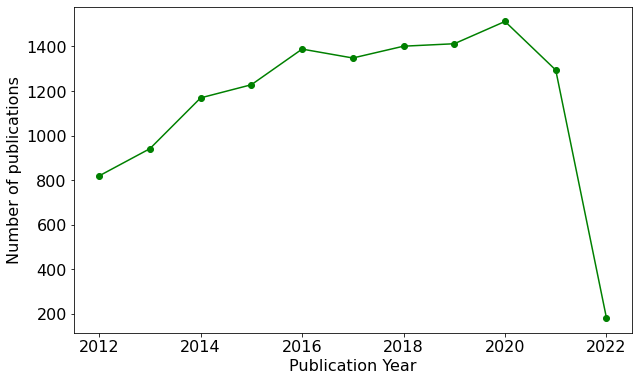

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

from collections import Counter
year_counter = pd.DataFrame.from_dict(
    Counter([a['publication_year'] for a in articles]),
    orient='index',
    columns=['pub_count']
).sort_index()

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(year_counter.index, year_counter['pub_count'], marker='o', color='green')
#ax.hist(cited_works_count.values(), bins=np.arange(0,25,1))
ax.set_xlabel("Publication Year")
ax.set_ylabel("Number of publications")
plt.show()